<a href="https://colab.research.google.com/github/NeZorinEgor/MachineVision-Learning/blob/main/horizon/horizon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import hough_line, hough_line_peaks
from itertools import combinations

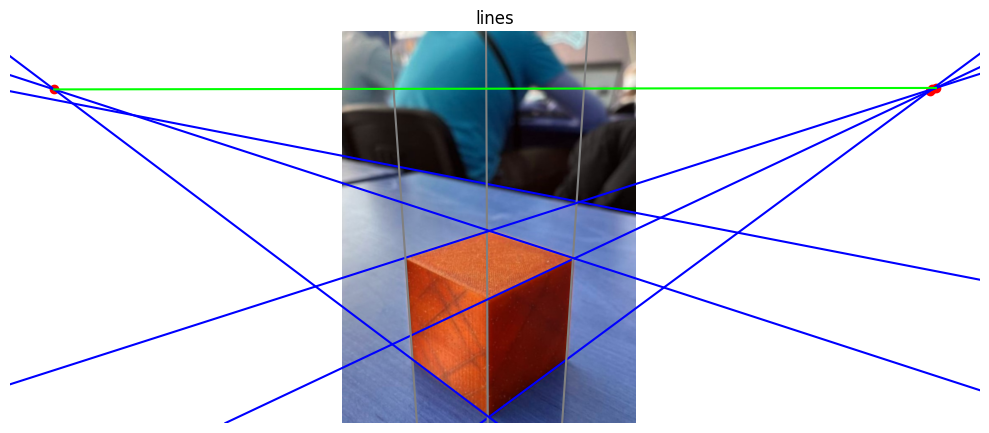

In [ ]:
image = cv2.imread('cube.jpg')
saturation = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[:, :, 1]

edges = cv2.Canny(saturation, 150, 200)

# Выполнение преобразования Хафа для обнаружения линий на обработанных краях изображения
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 720, endpoint=False)
h, theta, d = hough_line(edges, theta=tested_angles)

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(image)
ax.set_ylim((image.shape[0], 0))
ax.set_axis_off()
ax.set_title('lines')

lines = []

# Получение параметров обнаруженных линий и отображение их на графике
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    # Определение цвета линии в зависимости от угла наклона
    color = "gray" if np.abs(angle) < np.deg2rad(20) else "blue"
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])  # Начальная точка линии
    slope = np.tan(angle + np.pi / 2)  # Наклон линии
    ax.axline((x0, y0), slope=slope, c=color)  # Отрисовка линии на графике
    if np.abs(angle) > np.deg2rad(20):
        lines.append([-slope, x0 * slope - y0])  # Сохранение параметров линии

# Вычисление пересечений между линиями
def intersect_lines(line1, line2):
    a, b = line1
    u, v = line2
    fac = a - u
    val = -b + v
    x = val / fac
    y = a * x + b
    return x, y

xlist, ylist = [], []

# Получение всех комбинаций пар линий
for a, b in combinations(lines, 2):
    x, y = intersect_lines(a, b)  # Вычисление пересечения двух линий
    xlist.append(x)
    ylist.append(-y)  # Обратный знак, так как изображение имеет обратную ось y

# Выбор горизонтальной линии на основе пересечений
i, j = np.argmin(xlist), np.argmax(xlist)
x0, y0 = xlist[i], ylist[i]
x1, y1 = xlist[j], ylist[j]
slope = (y1 - y0) / (x1 - x0)
horizon = {'slope': slope, 'intercept': y0 - slope * x0}  # Параметры горизонта

horizon_points = []

# Нахождение точек, лежащих на горизонтальной линии
for x, y in zip(xlist, ylist):
    if np.isclose(y, horizon['slope'] * x + horizon['intercept'], atol=10):
        horizon_points.append((x, y))

horizon_x, horizon_y = zip(*horizon_points)

# Отображение точек горизонта на графике
ax.scatter(horizon_x, horizon_y, color='red', marker='o')

# Построение горизонтальной линии на графике
x_horizon = np.linspace(min(horizon_x), max(horizon_x), 100)
y_horizon = horizon['slope'] * x_horizon + horizon['intercept']
ax.plot(x_horizon, y_horizon, color='lime')

# Отображение графика
plt.tight_layout()
plt.show()
